### Some notes
This notebook contains a pre-trained Inceptionv3 with large learning rate, TTA and Grad-CAM.<br>
<br>**Likbez on topic:**
+ **Anatomy of the organ of vision:** <br>[[rus] 50 min video](https://www.youtube.com/watch?v=0OECPht72hA&list=LLDzSJMVSU9zgR9SJDynuxAA&index=6&t=0s) or [[rus] 5 min video](https://www.youtube.com/watch?v=TJN_9P8yQJU&list=LLDzSJMVSU9zgR9SJDynuxAA&index=11&t=0s)
+ **Classification of diabetic retinopathy:**
<br>
[[en] 16 min video](https://www.youtube.com/watch?v=IWspTG9wIsU&list=LLDzSJMVSU9zgR9SJDynuxAA&index=3&t=752s) or [[en] 13 min video](https://www.youtube.com/watch?v=VIrkurR446s&list=LLDzSJMVSU9zgR9SJDynuxAA&index=2&t=11s) or [1 min video](https://www.youtube.com/watch?v=mb0hGpo6LK4&list=LLDzSJMVSU9zgR9SJDynuxAA&index=4&t=0s) or [[en] 7 min text](https://nei.nih.gov/health/diabetic/retinopathy)
+ **Baseline from youtube channel "DevPRO":**<br>
[[rus] 38 min video](https://www.youtube.com/watch?v=jOsPYvRDUpE)

Also, I wrote a [**"bot-ophthalmologist"**](https://t.me/MedEyeBot/), including based on data from these competitions, and if you are interested in creating some kind of interface for other people to interact with your ml-models, then my [**repository**](https://github.com/OldBonhart/MedEyeService) can become a starting point, it contains the bot code and some notes for deployment on heroku, there you can see an example of a bunch of **api telegram** + **pythorch** + **heroku**.

In [1]:
import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

['aptos2019-blindness-detection', 'inceptionv3-6epoch']


In [2]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
sub = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
print('Dimensions:', train_df.shape, test_df.shape, sub.shape)

Dimensions: (3662, 2) (1928, 1) (1928, 2)


In [3]:
test_df['diagnosis'] = 0
test_df.head()

,id_code,diagnosis
0,0005cfc8afb6,0
1,003f0afdcd15,0
2,006efc72b638,0
3,00836aaacf06,0
4,009245722fa4,0


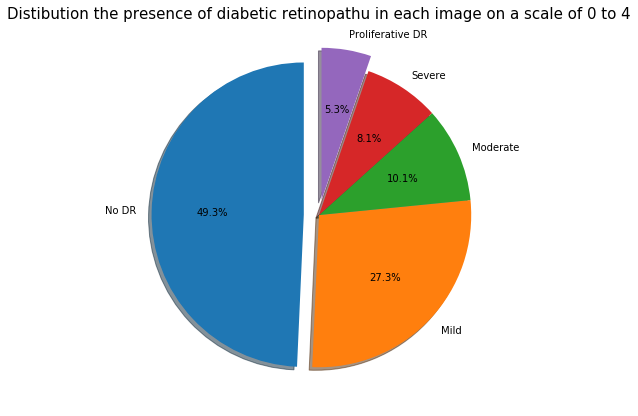

In [4]:
labels = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
explode = (0.1, 0, 0, 0, 0.1)

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(train_df['diagnosis'].value_counts(), explode=explode, labels=labels,
      autopct='%1.1f%%',shadow=True, startangle=90);

ax.set_title('Distibution the presence of diabetic retinopathu in each image on a scale of 0 to 4',
            fontdict={
                'fontsize':15
            });

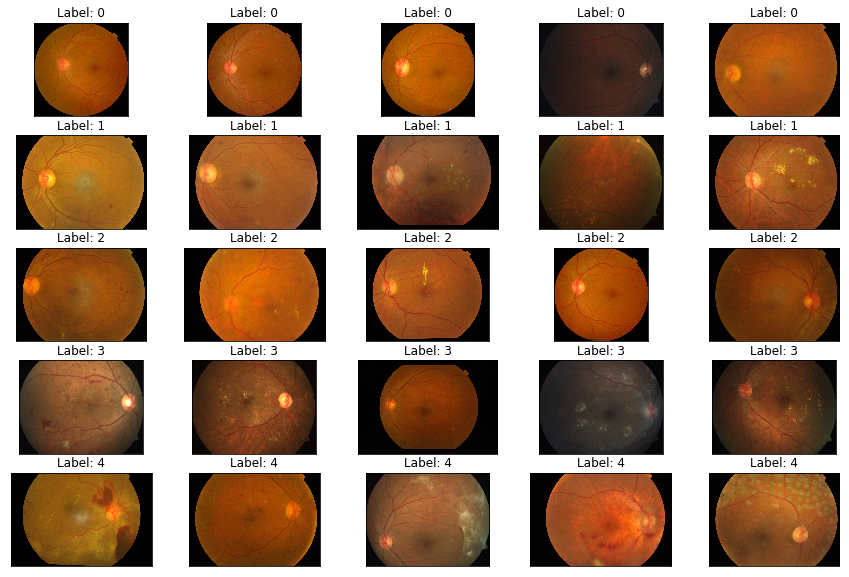

In [5]:
fig = plt.figure(figsize=(15, 10))
for label in sorted(train_df['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == label].sample(5).iterrows()):
        ax = fig.add_subplot(5, 5, label * 5 + i + 1, xticks=[], yticks=[])
        img = cv2.imread(f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png")
        plt.imshow(img[...,[2,1,0]])
        ax.set_title(f'Label: {label}')

# Data preprocessing

In [6]:
# code from https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping
# Image processing
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
    
def load_ben_color(path, sigmaX=10 ):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (512, 512))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

# Dataset and dataloader

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader 

import torchvision
from torchvision.transforms import transforms

In [8]:
# Dataset
class RetinaDataset(Dataset):
    def __init__(self, df, img_dir, transforms):
        self.df = df
        self.img_dir = img_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir,
                               self.df.iloc[idx, 0] + '.png')
        image = load_ben_color(img_name)
        image = self.transforms(image)
        label = self.df.iloc[idx, 1]
        return image, label

In [9]:
# Augmentations for train/test data
train_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(100),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
])
test_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# train/test dataset & dataloader
train_img_dir = '../input/aptos2019-blindness-detection/train_images/'
test_img_dir =  '../input/aptos2019-blindness-detection/test_images/'

train_dataset = RetinaDataset(df=train_df, img_dir=train_img_dir, transforms=train_aug)
test_dataset = RetinaDataset(df=test_df, img_dir=test_img_dir, transforms=test_aug)

train_loader = DataLoader(dataset=train_dataset, batch_size=16,shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

# Checking data

In [10]:
i, l = next(iter(train_loader))
i.shape, l.shape

(torch.Size([16, 3, 512, 512]), torch.Size([16]))

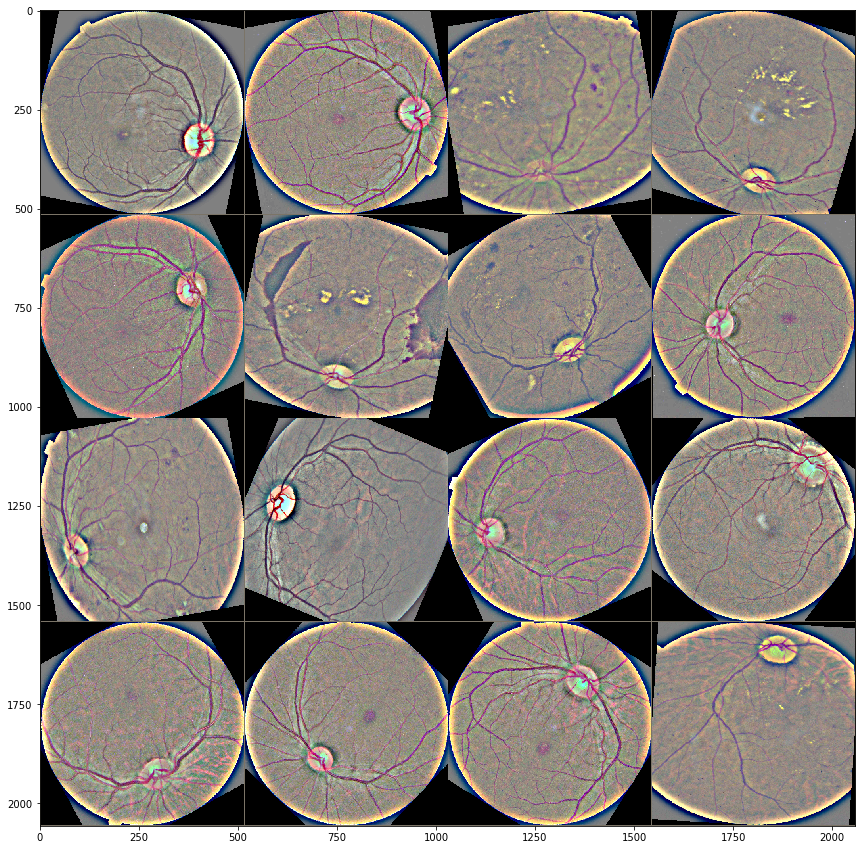

In [11]:
# Checking aug for tta
def show_aug(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,15))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

    
# Get a batch of training data
inputs, _ = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs,4)  

show_aug(out)

# Model

In [12]:
# Hyper parameters
num_epochs = 8
num_classes = 5
lr = 0.001

In [13]:
# Model initialization
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
f = '../input/inceptionv3-6epoch/inception3_6epoch.pt'

model = torchvision.models.inception_v3(pretrained=False, aux_logits = False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(f, map_location='cuda:0'))
model = model.to(device)

In [14]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)

In [15]:
# Training model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for batch_i, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (batch_i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                 .format(epoch+1, num_epochs, batch_i+1, total_step, loss.item()))
torch.save(model.state_dict(), 'model.pt')            

Epoch [1/8], Step [100/229], Loss: 0.7312
Epoch [1/8], Step [200/229], Loss: 0.4822
Epoch [2/8], Step [100/229], Loss: 0.8027
Epoch [2/8], Step [200/229], Loss: 0.5180
Epoch [3/8], Step [100/229], Loss: 0.7016
Epoch [3/8], Step [200/229], Loss: 0.9500
Epoch [4/8], Step [100/229], Loss: 0.6294
Epoch [4/8], Step [200/229], Loss: 0.8984
Epoch [5/8], Step [100/229], Loss: 0.4249
Epoch [5/8], Step [200/229], Loss: 0.4485
Epoch [6/8], Step [100/229], Loss: 0.6704
Epoch [6/8], Step [200/229], Loss: 0.5037
Epoch [7/8], Step [100/229], Loss: 0.4908
Epoch [7/8], Step [200/229], Loss: 0.4112
Epoch [8/8], Step [100/229], Loss: 0.4533
Epoch [8/8], Step [200/229], Loss: 0.5915


# TTA

In [16]:
# Augmentation data generators

aug1 = transforms.Compose([
       transforms.ToPILImage(),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])


aug2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomChoice([
            transforms.RandomRotation((0,0)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1),
            transforms.RandomRotation((90,90)),
            transforms.RandomRotation((180,180)),
            transforms.RandomRotation((270,270)),
        ]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
])


aug3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(100),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# Augmentation dataset & data loaders
test_dataset1 = RetinaDataset(df=test_df, img_dir=test_img_dir, transforms=aug1)
test_dataset2 = RetinaDataset(df=test_df, img_dir=test_img_dir, transforms=aug2)
test_dataset3 = RetinaDataset(df=test_df, img_dir=test_img_dir, transforms=aug3)

tl1 = DataLoader(dataset=test_dataset1, batch_size=16, shuffle=False)
tl2 = DataLoader(dataset=test_dataset2, batch_size=16, shuffle=False)
tl3 = DataLoader(dataset=test_dataset3, batch_size=16, shuffle=False)


In [17]:
tta_loaders = [tl1, tl2, tl3]

t1,t2,t3 = [], [], []
preds = [t1, t2, t3]
for i in range(len(tta_loaders)):
    with torch.no_grad():
        model.eval()
        for data, target in tta_loaders[i]:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            for probs in outputs:
                #print(prob)
                preds[i].append(probs.detach().cpu().numpy())
                
end = [(a+b+c) / 3 for a,b,c in zip(t1, t2, t3)]

predictions = []
for prob in end:   
    idx = np.argmax(prob)
    #pred = rectification(prob[idx])
    predictions.append(idx)

# Submission

In [18]:
sub['diagnosis'] =  predictions
sub.to_csv('submission.csv', index=False)
sub['diagnosis'].value_counts()

2    1046
0     429
4     205
3     128
1     120
Name: diagnosis, dtype: int64

# Heatmaps with ROI

In [19]:
# Extract  pretrained activations
class SaveFeatures():
    """ Extract pretrained activations"""
    features=None
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = ((output.cpu()).data).numpy()
    def remove(self):
        self.hook.remove()
        
final_layer = model._modules.get('Mixed_7c')
activated_features = SaveFeatures(final_layer)

In [20]:
## Probabilities & labels for each images
output = model(data[:8])# conver to cuda for softmax
probabilities = F.softmax(output,dim=1).data.squeeze()
pred_idx = np.argmax(probabilities.cpu().detach().numpy(),axis=1)
labels = pred_idx
activated_features.remove()
print('Probabilities classes: %s \n Prediction indices %s \n Labels: %s' % (probabilities, pred_idx, labels))

Probabilities classes: tensor([[1.2254e-05, 6.5687e-02, 7.6478e-01, 7.1374e-02, 9.8145e-02],
        [4.5288e-03, 3.1719e-01, 5.8060e-01, 3.2433e-02, 6.5250e-02],
        [3.1954e-06, 1.0830e-02, 6.4772e-01, 2.5051e-01, 9.0938e-02],
        [9.9817e-01, 9.0761e-04, 8.3458e-04, 4.2872e-05, 4.7947e-05],
        [2.4262e-03, 1.4041e-01, 7.4463e-01, 6.1739e-02, 5.0795e-02],
        [1.0337e-04, 4.9407e-02, 5.6330e-01, 1.4962e-01, 2.3757e-01],
        [1.1542e-04, 1.0236e-03, 4.8518e-02, 3.1280e-01, 6.3754e-01],
        [8.5564e-01, 7.7163e-02, 5.6623e-02, 8.4472e-04, 9.7312e-03]],
       device='cuda:0') 
 Prediction indices [2 2 2 0 2 2 4 0] 
 Labels: [2 2 2 0 2 2 4 0]


In [21]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv[0,:, :, ].reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return cam_img

weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
weight_softmax_params

[Parameter containing:
 tensor([[-0.1813,  0.0294,  0.0314,  ...,  0.0166, -0.1719, -0.0241],
         [ 0.0628, -0.0698,  0.0041,  ...,  0.0195, -0.0302, -0.0541],
         [ 0.0771, -0.0057, -0.0839,  ..., -0.0509,  0.0396, -0.0223],
         [-0.0173, -0.0479, -0.0128,  ..., -0.0235,  0.0135,  0.0053],
         [ 0.0630, -0.0584,  0.0634,  ...,  0.0221,  0.0016,  0.0497]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-0.2048,  0.0017,  0.2033, -0.0930,  0.0302], device='cuda:0',
        requires_grad=True)]

In [22]:
## Current images & their heatmaps
cur_images = data.cpu().numpy().transpose((0, 2, 3, 1))
heatmaps = []
for i in pred_idx:
    img = getCAM(activated_features.features, weight_softmax, i)
    heatmaps.append(img)
    
print(cur_images.shape, len(heatmaps))

(8, 512, 512, 3) 8


In [23]:
# Probability for each images
proba = []
for i in probabilities.cpu().detach().numpy():
    idx = np.argmax(i)
    proba.append((str(np.round(i[idx]*100,2)))+'%')
print(proba)

['76.48%', '58.06%', '64.77%', '99.82%', '74.46%', '56.33%', '63.75%', '85.56%']


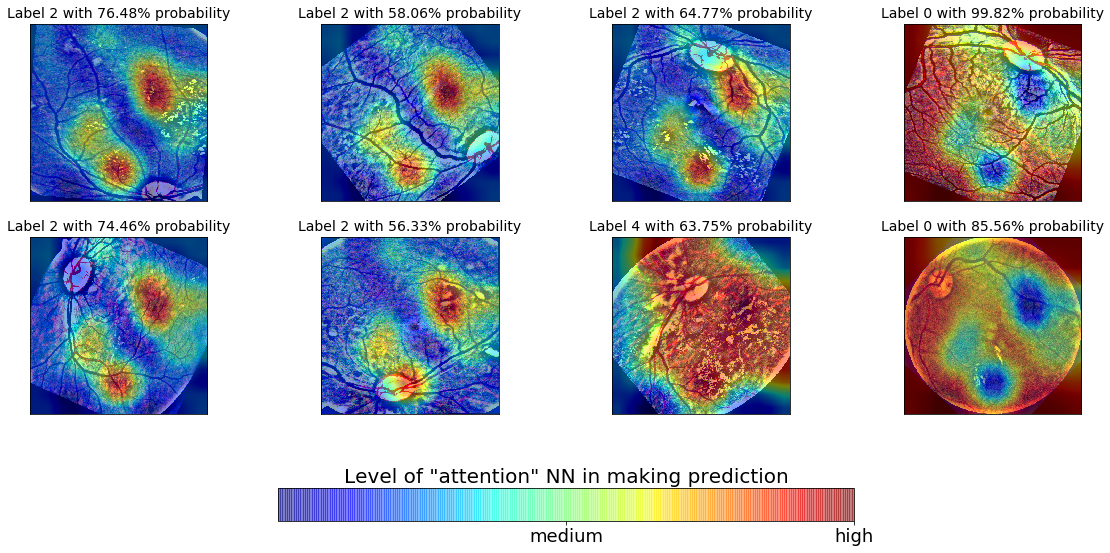

In [24]:
fig=plt.figure(figsize=(20,15))
for i in range(0, len(cur_images[:8])):
    img = cur_images[i]
    mask = heatmaps[i]
    ax = fig.add_subplot(4, 4,i +1,xticks=[], yticks=[])
    plt.imshow(img)
    plt.imshow(cv2.resize(mask, (512,512), interpolation=cv2.INTER_LINEAR), alpha=0.5, cmap='jet');
    ax.set_title('Label %d with %s probability' % (labels[i], proba[i]),fontsize=14)
    
#cax = fig.add_axes([0.3, 0.42, 0.4, 0.04]) # place where be map
cax = fig.add_axes([0.32, 0.42, 0.4, 0.03]) # place where be map
clb = plt.colorbar(cax=cax, orientation='horizontal',ticks=[0, 0.5, 1])
clb.ax.set_title('Level of "attention" NN in making prediction',fontsize=20)
clb.ax.set_xticklabels(['low', 'medium', 'high'],fontsize=18)


plt.show()